In [1]:
%load_ext autoreload
%autoreload 2

import functools
import time

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import gpjax as gpx
import optax

from bay_sbi import embedding_models
from bay_sbi import maf_flow
from bay_sbi import train
from bay_sbi import two_moons

jax.devices()

2024-11-14 12:10:48.111607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-14 12:10:48.129785: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-14 12:10:48.134600: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 12:10:50.149297: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1731604254.434900  919302 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


[gpu(id=0)]

## Problem Setup

In [2]:
draw_batch = jax.jit(jax.vmap(two_moons.draw_joint_two_moons))
draw_obs = jax.jit(jax.vmap(two_moons.draw_two_moons, in_axes=[0, None]))
draw_obs_conds = jax.jit(jax.vmap(two_moons.draw_two_moons))
draw_thetas = jax.jit(jax.vmap(two_moons.draw_param, in_axes=[0, None]))
draw_thetas_cond = jax.jit(jax.vmap(two_moons.draw_param))

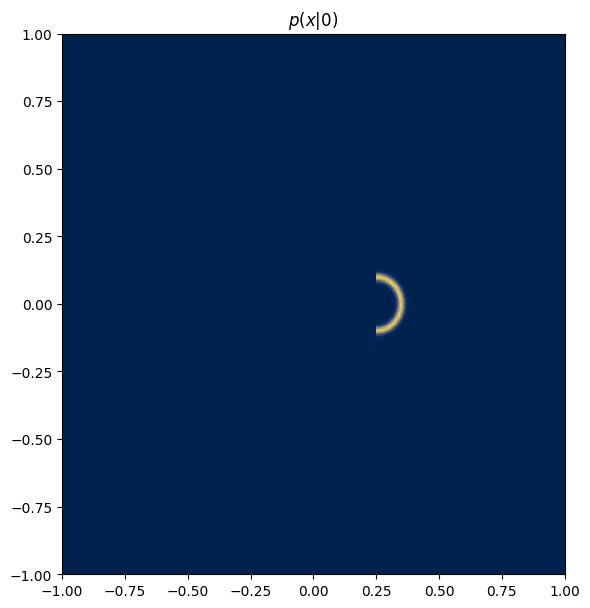

In [3]:
# Plot some distributions to get a sense of the two moons problem
batch_size = 1_000_000
rng = jax.random.PRNGKey(0)
rng_batch = jax.random.split(rng, batch_size)
x_samples = draw_obs(rng_batch, jnp.array([0.0, 0.0]))

fig = plt.figure(figsize=(6, 6))
n_bins = 1000
plt.hist2d(
    x_samples[:, 0], x_samples[:, 1],
    bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
)
plt.tight_layout()
plt.title(r'$p(x|0)$')
plt.show()

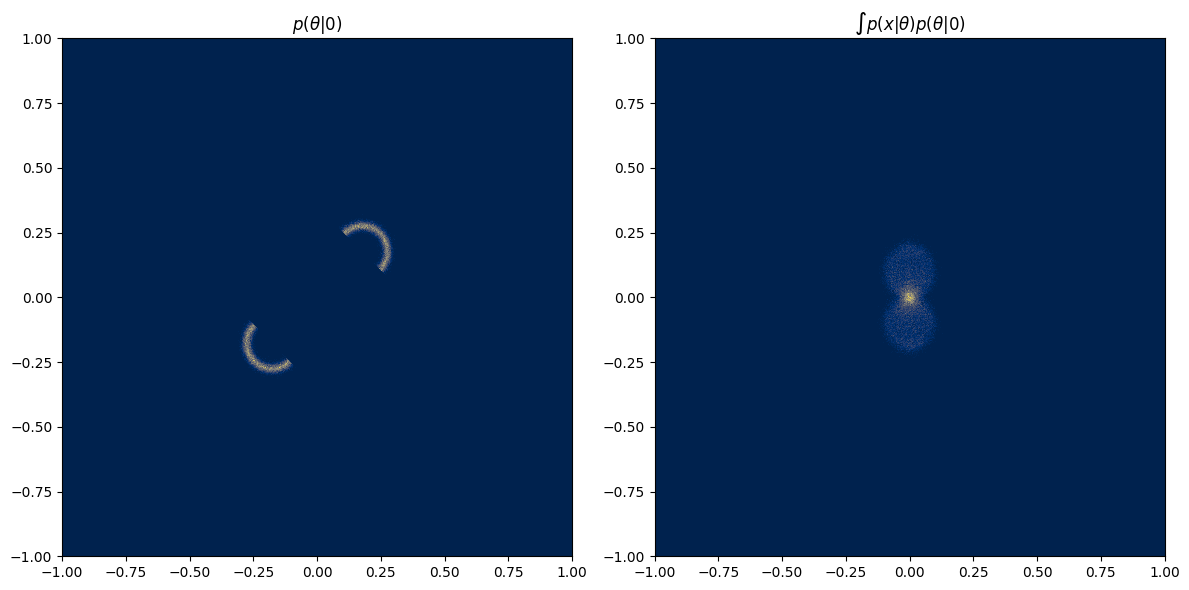

In [4]:
# Plot our target distribution for our context of 0.
batch_size = 100_000
rng = jax.random.PRNGKey(0)
rng_batch = jax.random.split(rng, batch_size)
theta_p_x = draw_thetas(rng_batch, jnp.array([0.0, 0.0]))
x_p_x = draw_obs_conds(rng_batch, theta_p_x)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
n_bins = 1000
ax[0].set_title(r'$p(\theta|0)$')
ax[0].hist2d(
    theta_p_x[:, 0], theta_p_x[:, 1],
    bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
)
ax[1].set_title(r'$\int p(x|\theta)p(\theta|0)$')
ax[1].hist2d(
    x_p_x[:, 0], x_p_x[:, 1],
    bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
)
plt.tight_layout()
plt.show()

- Quadrant prior mixture
- Bayesian optimization in a changing world (with some drift)

## Training Setup

In [1]:
parameter_dim = 2
n_maf_layers = 5
hidden_dims_maf = [50, 50]
hidden_layers_mlp = []
activation_mlp ='gelu'
activation_maf = 'tanh'
context_dim = 2

embedding_module = embedding_models.MLP(context_dim, hidden_layers_mlp, activation_mlp)
flow_module = maf_flow.MAF(parameter_dim, n_maf_layers, hidden_dims_maf, activation_maf)
model = maf_flow.EmbeddedFlow(embedding_module, flow_module)

# Initialize the train state.
rng = jax.random.PRNGKey(1)
optimizer = 'adam'
learning_rate = 1e-3
batch_size = 4
sample_shape = (4096,)
learning_rate_schedule = optax.exponential_decay(
    learning_rate, 1024, 1.0
)
state = train.create_train_state_nf(
    rng, optimizer, model, context_dim, parameter_dim, learning_rate_schedule
)

# Create compiled version of functions.
sample_func = jax.jit(
    functools.partial(state.apply_fn, method='sample', mutable=('batch_stats',)),
    static_argnames=['sample_shape',]
)
log_prob_func = jax.jit(
    functools.partial(state.apply_fn, mutable=('batch_stats',))
)
extract_flow_context = jax.jit(train.extract_flow_context)

# If you change the underlying model, you must create a new train_step function since it depends on the
# optimizer mask which depends on the maf_model structure.
train_step = jax.jit(train.train_step, static_argnames=['learning_rate_schedule', 'n_atoms'])

NameError: name 'embedding_models' is not defined

In [43]:
x_obs = jnp.zeros((2))

def train_state(
    x_dataset, theta_dataset, rng, state, n_epochs, batch_size
):
    """Train model from starting state using provided dataset"""

    mu_prior = jnp.zeros(2)
    prec_prior = jnp.zeros((2, 2)) # Equivalent to uniform prior.

    # Timing
    train_metrics_last_t = time.time()

    for epoch in range(n_epochs):

        # Sample a batch
        rng, rng_perm = jax.random.split(rng)
        dataset_size = len(x_dataset)
        n_atoms = min(batch_size, 128)

        # Create a batch of indices truncating indices that don't fit in the
        # batch size.
        indices_batch = jax.random.permutation(rng, dataset_size)
        indices_batch = indices_batch[dataset_size % batch_size:]
        indices_batch = indices_batch.reshape((-1, batch_size))

        for indices in indices_batch:
            x_batch = x_dataset[indices]
            theta_batch = theta_dataset[indices]
            batch = {'truth': theta_batch, 'context': x_batch}

            # Update
            state, metrics = train_step(
                rng, state, batch, mu_prior, prec_prior,
                learning_rate_schedule=learning_rate_schedule, n_atoms=n_atoms
            )

        # Report metrics at the end of each epoch.
        metrics['steps_per_second'] = (
            len(indices_batch) / (time.time() - train_metrics_last_t)
        )
        train_metrics_last_t = time.time()
        log_obs_prob, _ = log_prob_func(
            {'params': state.params, 'batch_stats': state.batch_stats},
            theta_p_x, jnp.zeros_like(x_p_x)
        )
        metrics['kl'] = -jnp.mean(log_obs_prob)
        # print(
        #     f'epoch {(epoch+1):>{2}}:',
        #     jax.tree_map(lambda x: f'{float(x):.3g}', metrics)
        # )

    kl = -jnp.mean(log_obs_prob)

    return state, kl


flow_apply = jax.jit(
    flow_module.apply, static_argnames=['sample_shape', 'method']
)
def sample_thetas(rng, flow_params, context, theta_samp_func, flow_weight):
    """Sample a mixture of the flow outputs and the prior controlled by the
    weight"""
    rng_prior, rng_flow = jax.random.split(rng)

    truth_from_prior = theta_samp_func(rng_prior)

    truth_from_flow = flow_apply(
        flow_params, rng_flow, context, sample_shape=truth_from_prior.shape[:1],
        method='sample'
    )

    # Determine the ratio based off of the flow weight.
    flow_mask = jnp.expand_dims(
        jnp.linspace(0, 1, batch_size) < flow_weight, axis=-1
    )

    truth = truth_from_flow * flow_mask
    truth += truth_from_prior * (~flow_mask)

    return truth

## $f_\mathrm{post} = 0.0$

Train a model where every example is drawn from the prior (equivalent to NPE).

In [101]:
# The prior distribution and the flow from which we will sample.
theta_samp_func = functools.partial(
    jax.random.uniform, shape=(batch_size, 2), minval=-2.0, maxval=2.0
)
# For the flow we also need the context produced by our observation.
flow_params, context = extract_flow_context(state, x_obs)

# Keep a list of the state after each epoch.
rng = jax.random.PRNGKey(0)
state_list_prior = [state]
kl_list_prior = []
kl_list_prior_approx = []

# Draw the first batch and train our model.
rng_train, rng_theta, rng_x, rng = jax.random.split(rng, 4)
thetas = sample_thetas(rng, flow_params, context, theta_samp_func, 0.0)
rng_batch = jax.random.split(rng_x, batch_size)
xs = draw_obs_conds(rng_batch, thetas)

rng = jax.random.PRNGKey(2)
n_seq = 200
n_epochs = 10
for seq_round in range(n_seq):
    print(f'Sequential round {seq_round}')
    # Train the model for the desired number of epochs.
    rng_train, rng_theta, rng = jax.random.split(rng, 3)
    state_train, kl = train_state(
        xs, thetas, rng_train, state_list_prior[-1], n_epochs, min(128, len(xs))
    )

    # Save the new state and the kl.
    state_list_prior.append(state_train)
    kl_list_prior.append(kl)

    # Draw samples from the flow itself to approximate the kl. Can be compared
    # to the true KL.
    approx_samples, _ = sample_func(
        {'params': state_train.params, 'batch_stats': state_train.batch_stats},
        rng, x_obs[None],
        sample_shape=sample_shape
    )
    log_obs_prob, _ = log_prob_func(
        {'params': state_train.params, 'batch_stats': state_train.batch_stats},
        approx_samples[0], jnp.zeros_like(approx_samples[0])
    )
    kl_list_prior_approx.append(-jnp.mean(log_obs_prob))

    # Get the new flow from the model.
    flow_params, context = extract_flow_context(state_train, x_obs)

    # Generate the new batch.
    theta_batch = sample_thetas(
        rng_theta, flow_params, context, theta_samp_func, 0.0
    )
    rng_batch = jax.random.split(rng, batch_size)
    x_batch = draw_obs_conds(rng_batch, theta_batch)

    # Append them to our dataset.
    thetas = jnp.append(thetas, theta_batch, axis=0)
    xs = jnp.append(xs, x_batch, axis=0)


Sequential round 0
Sequential round 1
Sequential round 2
Sequential round 3
Sequential round 4
Sequential round 5
Sequential round 6
Sequential round 7
Sequential round 8
Sequential round 9
Sequential round 10
Sequential round 11
Sequential round 12
Sequential round 13
Sequential round 14
Sequential round 15
Sequential round 16
Sequential round 17
Sequential round 18
Sequential round 19
Sequential round 20
Sequential round 21
Sequential round 22
Sequential round 23
Sequential round 24
Sequential round 25
Sequential round 26
Sequential round 27
Sequential round 28
Sequential round 29
Sequential round 30
Sequential round 31
Sequential round 32
Sequential round 33
Sequential round 34
Sequential round 35
Sequential round 36
Sequential round 37
Sequential round 38
Sequential round 39
Sequential round 40
Sequential round 41
Sequential round 42
Sequential round 43
Sequential round 44
Sequential round 45
Sequential round 46
Sequential round 47
Sequential round 48
Sequential round 49
Sequential

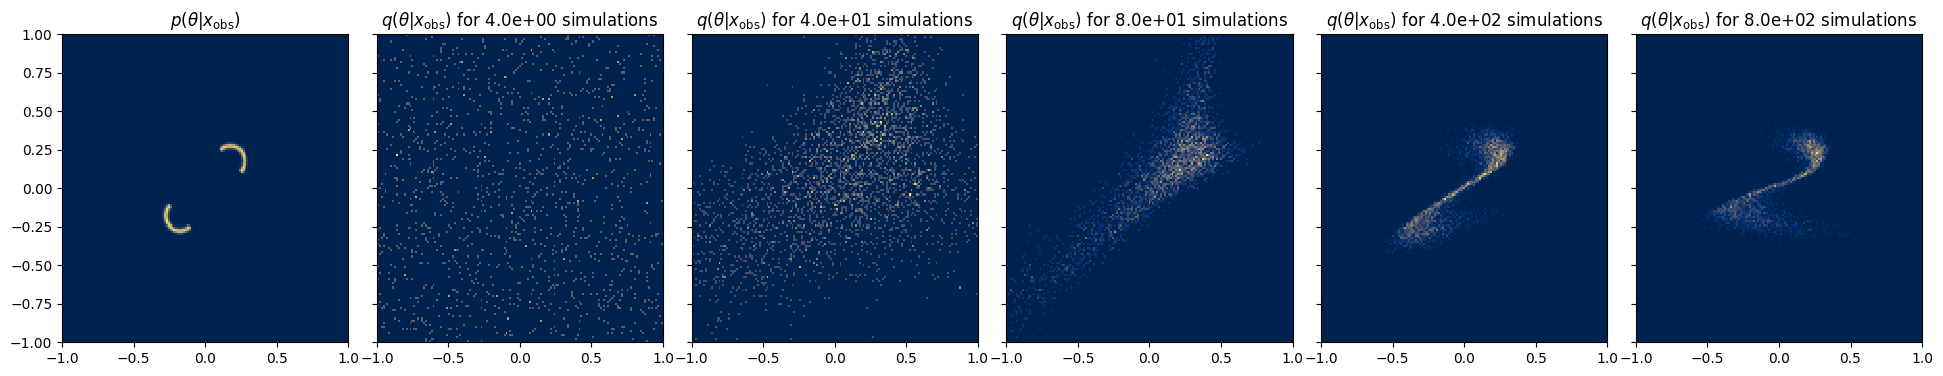

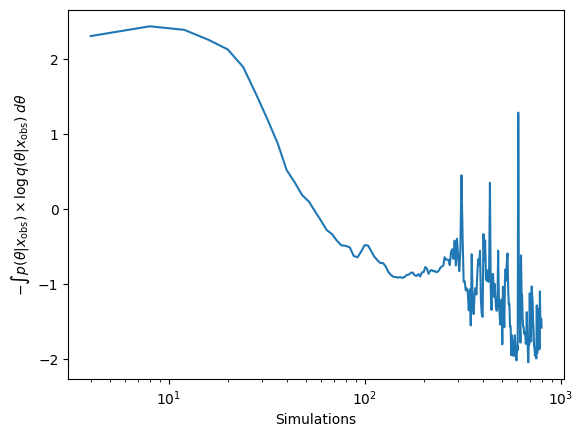

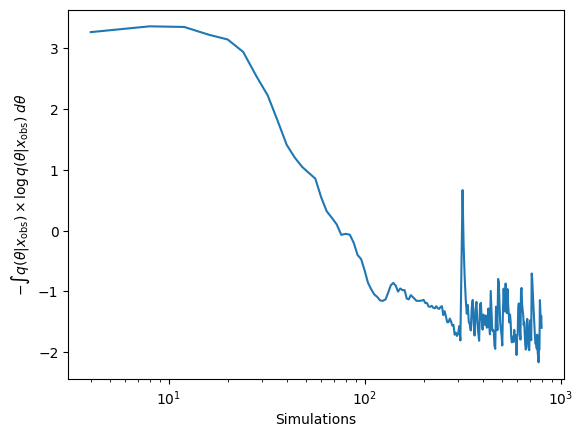

In [102]:
plt_indices = [1, 10, 20, 100, 200]

fig, ax = plt.subplots(
    1, len(plt_indices) + 1, figsize=(4 * (len(plt_indices) + 1),4), sharey=True,
    gridspec_kw={'hspace': 0.02,'wspace':0.1}, dpi=100
)
n_bins = 150

ax[0].set_title(r'$p(\theta|x_\mathrm{obs})$')
ax[0].hist2d(
    theta_p_x[:, 0], theta_p_x[:, 1],
    bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
)

for plt_i, i in enumerate(plt_indices):
    t_samp, _ = sample_func(
        {'params': state_list_prior[i].params, 'batch_stats': state_list_prior[i].batch_stats},
        rng, x_obs[None],
        sample_shape=sample_shape
    )
    t_samp = jnp.squeeze(t_samp)
    ax[plt_i+1].set_title(r'$q(\theta|x_\mathrm{obs})$ ' + f'for {batch_size * (i):.1e} simulations')
    ax[plt_i+1].hist2d(
        t_samp[:, 0], t_samp[:, 1],
        bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
    )
plt.show()

plt.plot(jnp.arange(1, len(kl_list_prior)+1) * batch_size, jnp.array(kl_list_prior))
plt.xlabel('Simulations')
plt.xscale('log')
plt.ylabel(r'$-\int p(\theta|x_\mathrm{obs}) \times \log q(\theta|x_\mathrm{obs}) \ d\theta$')
plt.show()

plt.plot(jnp.arange(1, len(kl_list_prior)+1) * batch_size, jnp.array(kl_list_prior_approx))
plt.xlabel('Simulations')
plt.xscale('log')
plt.ylabel(r'$-\int q(\theta|x_\mathrm{obs}) \times \log q(\theta|x_\mathrm{obs}) \ d\theta$')
plt.show()

## $f_\mathrm{post} = 1.0$

Train a model where every new example is drawn from the posterior (SNPE-C)

In [103]:
# The prior distribution and the flow from which we will sample.
theta_samp_func = functools.partial(
    jax.random.uniform, shape=(batch_size, 2), minval=-2.0, maxval=2.0
)
# For the flow we also need the context produced by our observation.
flow_params, context = extract_flow_context(state, x_obs)

# Keep a list of the state after each epoch.
rng = jax.random.PRNGKey(0)
state_list_post = [state]
kl_list_post = []
kl_list_post_approx = []

# Draw the first batch and train our model.
rng_train, rng_theta, rng_x, rng = jax.random.split(rng, 4)
thetas = sample_thetas(rng, flow_params, context, theta_samp_func, 0.0)
rng_batch = jax.random.split(rng_x, batch_size)
xs = draw_obs_conds(rng_batch, thetas)

rng = jax.random.PRNGKey(2)
n_seq = 200
n_epochs = 10
for seq_round in range(n_seq):
    print(f'Sequential round {seq_round}')
    # Train the model for the desired number of epochs.
    rng_train, rng_theta, rng = jax.random.split(rng, 3)
    state_train, kl = train_state(
        xs, thetas, rng_train, state_list_post[-1], n_epochs, min(128, len(xs))
    )

    # Save the new state and the kl.
    state_list_post.append(state_train)
    kl_list_post.append(kl)

    # Draw samples from the flow itself to approximate the kl. Can be compared
    # to the true KL.
    approx_samples, _ = sample_func(
        {'params': state_train.params, 'batch_stats': state_train.batch_stats},
        rng, x_obs[None],
        sample_shape=sample_shape
    )
    log_obs_prob, _ = log_prob_func(
        {'params': state_train.params, 'batch_stats': state_train.batch_stats},
        approx_samples[0], jnp.zeros_like(approx_samples[0])
    )
    kl_list_post_approx.append(-jnp.mean(log_obs_prob))

    # Get the new flow from the model.
    flow_params, context = extract_flow_context(state_train, x_obs)

    # Generate the new batch.
    theta_batch = sample_thetas(
        rng_theta, flow_params, context, theta_samp_func, 0.8
    )
    rng_batch = jax.random.split(rng, batch_size)
    x_batch = draw_obs_conds(rng_batch, theta_batch)

    # Append them to our dataset.
    thetas = jnp.append(thetas, theta_batch, axis=0)
    xs = jnp.append(xs, x_batch, axis=0)


Sequential round 0
Sequential round 1
Sequential round 2
Sequential round 3
Sequential round 4
Sequential round 5
Sequential round 6
Sequential round 7
Sequential round 8
Sequential round 9
Sequential round 10
Sequential round 11
Sequential round 12
Sequential round 13
Sequential round 14
Sequential round 15
Sequential round 16
Sequential round 17
Sequential round 18
Sequential round 19
Sequential round 20
Sequential round 21
Sequential round 22
Sequential round 23
Sequential round 24
Sequential round 25
Sequential round 26
Sequential round 27
Sequential round 28
Sequential round 29
Sequential round 30
Sequential round 31
Sequential round 32
Sequential round 33
Sequential round 34
Sequential round 35
Sequential round 36
Sequential round 37
Sequential round 38
Sequential round 39
Sequential round 40
Sequential round 41
Sequential round 42
Sequential round 43
Sequential round 44
Sequential round 45
Sequential round 46
Sequential round 47
Sequential round 48
Sequential round 49
Sequential

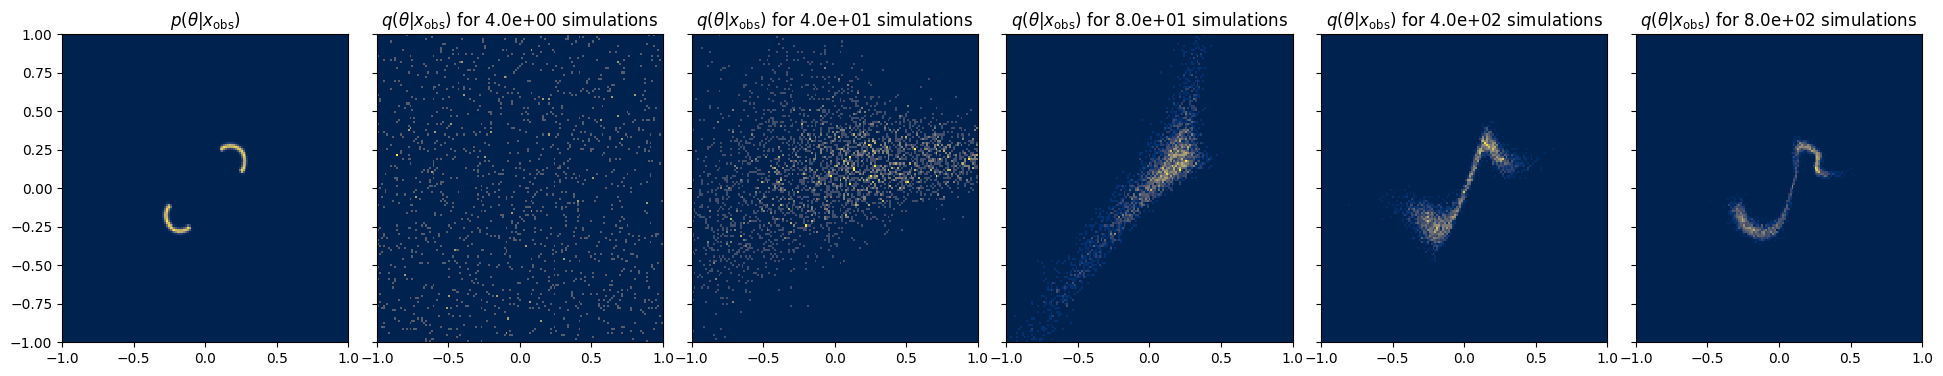

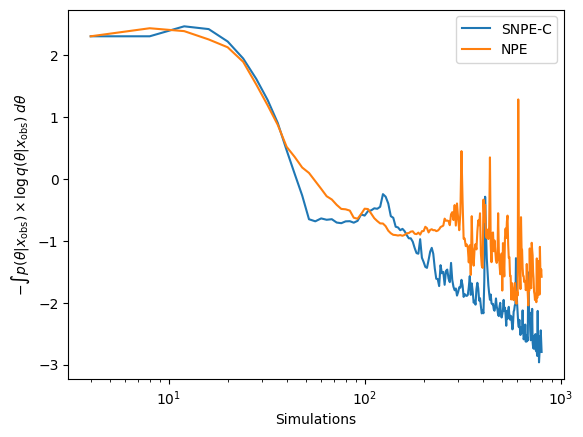

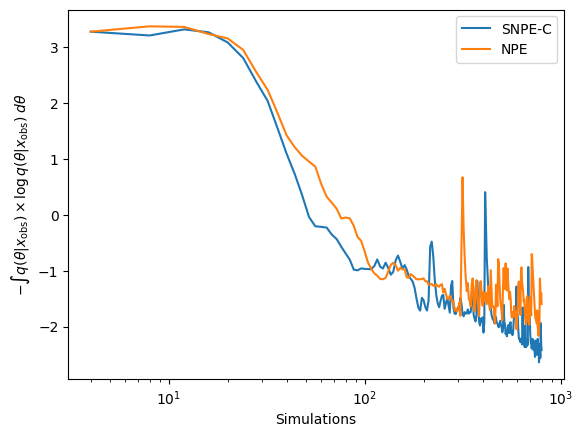

In [105]:
plt_indices = [1, 10, 20, 100, 200]
sample_shape = (4096,)

fig, ax = plt.subplots(
    1, len(plt_indices) + 1, figsize=(4 * (len(plt_indices) + 1),4), sharey=True,
    gridspec_kw={'hspace': 0.02,'wspace':0.1}, dpi=100
)
n_bins = 150

ax[0].set_title(r'$p(\theta|x_\mathrm{obs})$')
ax[0].hist2d(
    theta_p_x[:, 0], theta_p_x[:, 1],
    bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
)

for plt_i, i in enumerate(plt_indices):
    t_samp, _ = sample_func(
        {'params': state_list_post[i].params, 'batch_stats': state_list_post[i].batch_stats},
        rng, x_obs[None],
        sample_shape=sample_shape
    )
    t_samp = jnp.squeeze(t_samp)
    ax[plt_i+1].set_title(r'$q(\theta|x_\mathrm{obs})$ ' + f'for {batch_size * (i):.1e} simulations')
    ax[plt_i+1].hist2d(
        t_samp[:, 0], t_samp[:, 1],
        bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
    )
plt.show()

plt.plot(jnp.arange(1, len(kl_list_post)+1) * batch_size, jnp.array(kl_list_post))
plt.plot(jnp.arange(1, len(kl_list_prior)+1) * batch_size, jnp.array(kl_list_prior))
plt.xlabel('Simulations')
plt.xscale('log')
plt.legend(['SNPE-C', 'NPE'])
plt.ylabel(r'$-\int p(\theta|x_\mathrm{obs}) \times \log q(\theta|x_\mathrm{obs}) \ d\theta$')
plt.show()

plt.plot(jnp.arange(1, len(kl_list_post)+1) * batch_size, jnp.array(kl_list_post_approx))
plt.plot(jnp.arange(1, len(kl_list_prior)+1) * batch_size, jnp.array(kl_list_prior_approx))
plt.xlabel('Simulations')
plt.xscale('log')
plt.legend(['SNPE-C', 'NPE'])
plt.ylabel(r'$-\int q(\theta|x_\mathrm{obs}) \times \log q(\theta|x_\mathrm{obs}) \ d\theta$')
plt.show()

## $f_\mathrm{post}$ Bayesian Optimization

Train a model where the fraction is selected through Bayesian optimization.

In [115]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from scipy.stats import norm

def expected_improvement(mean, sigma, f_prime):
    a_ei = (f_prime - mean) * norm.cdf(f_prime, loc=mean, scale=sigma)
    a_ei += sigma ** 2 * norm.pdf(f_prime, loc=mean, scale=sigma)
    return a_ei

def get_new_gp():
    kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1e0, (1e-3, 1e3)) + WhiteKernel(1e-2, (1e-3, 1e3))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-10)
    return gp
gp = get_new_gp()

0.5065065065065065


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


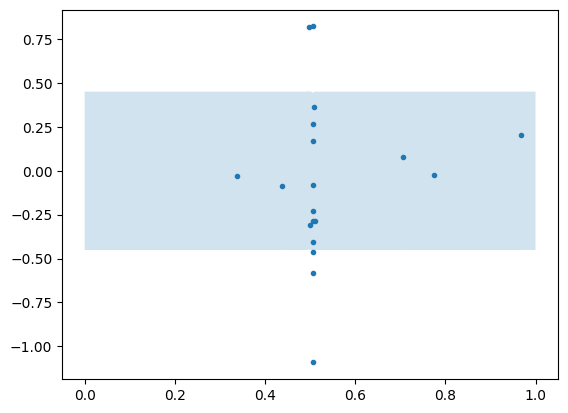

In [130]:
gp.fit(np.array(frac_dif_list)[:,None], kl_dif_list_bo)
mean, sigma = gp.predict(frac_test[:,None], return_std=True)
next_index = np.argmax(expected_improvement(mean, sigma, np.min(frac_dif_list)))
flow_weight = frac_test[next_index]
print(flow_weight)

mean, sigma = gp.predict(frac_test[:,None], return_std=True)
plt.plot(frac_dif_list, kl_dif_list_bo, '.')
plt.fill_between(
    frac_test, (mean-sigma), (mean+sigma), alpha=0.2
)
plt.show()

In [129]:
# The prior distribution and the flow from which we will sample.
theta_samp_func = functools.partial(
    jax.random.uniform, shape=(batch_size, 2), minval=-1.0, maxval=1.0
)
# For the flow we also need the context produced by our observation.
flow_params, context = extract_flow_context(state, x_obs)

# Keep a list of the state after each epoch.
rng = jax.random.PRNGKey(0)
state_list_bo = [state]
kl_list_bo = []
kl_dif_list_bo = []
frac_dif_list = []

# Draw the first batch and train our model.
rng_train, rng_theta, rng_x, rng = jax.random.split(rng, 4)
flow_weight = 0.5
thetas = sample_thetas(rng, flow_params, context, theta_samp_func, 0.0)
rng_batch = jax.random.split(rng_x, batch_size)
xs = draw_obs_conds(rng_batch, thetas)

rng = jax.random.PRNGKey(2)
n_seq = 20
n_epochs = 10
frac_test = np.linspace(0.0, 1.0, 1000)
for seq_round in range(n_seq):
    print(f'Sequential round {seq_round}, {flow_weight}')
    # Train the model for the desired number of epochs.
    rng_train, rng_theta, rng = jax.random.split(rng, 3)
    state_train, kl = train_state(
        xs, thetas, rng_train, state_list_bo[-1], n_epochs, min(128, len(xs))
    )

    # Save the new state and the kl.
    state_list_bo.append(state_train)
    kl_list_bo.append(kl)
    if seq_round > 0:
        kl_dif_list_bo.append(kl_list_bo[-1] - kl_list_bo[-2])
        frac_dif_list.append(flow_weight)
        if seq_round > 5:
            gp.fit(np.array(frac_dif_list)[:,None], kl_dif_list_bo)
            mean, sigma = gp.predict(frac_test[:,None], return_std=True)
            next_index = np.argmax(expected_improvement(mean, sigma, np.min(frac_dif_list)))
            flow_weight = frac_test[next_index]
        else:
            flow_weight = jax.random.uniform(rng)

    # Get the new flow from the model.
    flow_params, context = extract_flow_context(state_train, x_obs)

    # Generate the new batch.
    theta_batch = sample_thetas(
        rng_theta, flow_params, context, theta_samp_func, flow_weight
    )
    rng_batch = jax.random.split(rng, batch_size)
    x_batch = draw_obs_conds(rng_batch, theta_batch)

    # Append them to our dataset.
    thetas = jnp.append(thetas, theta_batch, axis=0)
    xs = jnp.append(xs, x_batch, axis=0)


Sequential round 0, 0.5
Sequential round 1, 0.5
Sequential round 2, 0.9686962366104126
Sequential round 3, 0.7055308818817139
Sequential round 4, 0.33790647983551025
Sequential round 5, 0.43701374530792236
Sequential round 6, 0.7743562459945679
Sequential round 7, 0.5055055055055055
Sequential round 8, 0.5115115115115115
Sequential round 9, 0.5075075075075075
Sequential round 10, 0.5065065065065065
Sequential round 11, 0.5075075075075075
Sequential round 12, 0.5095095095095095


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 13, 0.5055055055055055
Sequential round 14, 0.4964964964964965


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 15, 0.5065065065065065
Sequential round 16, 0.5065065065065065
Sequential round 17, 0.5065065065065065


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Sequential round 18, 0.5065065065065065
Sequential round 19, 0.5065065065065065


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:
plt_indices = [1, 10, 20, 100, 200]
sample_shape = (4096,)

fig, ax = plt.subplots(
    1, len(plt_indices) + 1, figsize=(4 * (len(plt_indices) + 1),4), sharey=True,
    gridspec_kw={'hspace': 0.02,'wspace':0.1}, dpi=100
)
n_bins = 150

ax[0].set_title(r'$p(\theta|x_\mathrm{obs})$')
ax[0].hist2d(
    theta_p_x[:, 0], theta_p_x[:, 1],
    bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
)

for plt_i, i in enumerate(plt_indices):
    t_samp, _ = sample_func(
        {'params': state_list_cons[i].params, 'batch_stats': state_list_cons[i].batch_stats},
        rng, x_obs[None],
        sample_shape=sample_shape
    )
    t_samp = jnp.squeeze(t_samp)
    ax[plt_i+1].set_title(r'$q(\theta|x_\mathrm{obs})$ ' + f'for {batch_size * (i):.1e} simulations')
    ax[plt_i+1].hist2d(
        t_samp[:, 0], t_samp[:, 1],
        bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
    )
plt.show()

plt.plot(jnp.arange(1, len(kl_list_cons)+1) * batch_size, jnp.array(kl_list_cons))
plt.plot(jnp.arange(1, len(kl_list_post)+1) * batch_size, jnp.array(kl_list_post))
plt.plot(jnp.arange(1, len(kl_list_prior)+1) * batch_size, jnp.array(kl_list_prior))
plt.xlabel('Simulations')
plt.xscale('log')
plt.ylabel(r'$-\int p(\theta|x_\mathrm{obs}) \times \log q(\theta_\mathrm{obs}|x_\mathrm{obs})$')
plt.show()